In [294]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

In [295]:
class MyDecisionTreeClassifier():
    class Node():
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.info_gain = info_gain

            self.value = value

    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth < self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return self.Node(best_split["feature_index"], best_split["threshold"],
                                 left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return self.Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                dataset_left = dataset[dataset[:, feature_index] <= threshold]
                dataset_right = dataset[dataset[:, feature_index] > threshold]
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    # y, left_y, right_y =
                    curr_info_gain = self.information_gain(dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1],
                                                           "entropy")
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        # def split(self, X, Y, feature_index, threshold):
        X_left = []
        X_right = []
        for i, row in enumerate(dataset):
            if row[feature_index] <= threshold:
                X_left.append(row)
            else:
                X_right.append(row)

        return np.array(X_left), np.array(X_right)

    def information_gain(self, parent, l_child, r_child, mode="entropy"):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, Y):

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        # dataset = np.concatenate((X, Y), axis=1)
        dataset = np.column_stack((X, Y))
        self.root = self.build_tree(dataset)

    def predict(self, X):

        pred = np.empty(shape=len(X))

        for i in range(len(X)):
            pred[i] = self.make_prediction(X[i], self.root)

        return pred

        # preditions = [self.make_prediction(x, self.root) for x in X]
        # return preditions

    def make_prediction(self, x, tree):

        if tree.value is not None:
            return tree.value

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [296]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, silent=False):

    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_test)

    if not silent:
        mesh_data = c_[xx.ravel(), yy.ravel()]
        Z = Z = np.asarray(mdl.predict(mesh_data)).reshape(xx.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(xx, yy, Z, alpha=0.6, cmap = 'ocean')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

        cm_model = confusion_matrix(y_test, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_test, mdl.predict(X_test))

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))



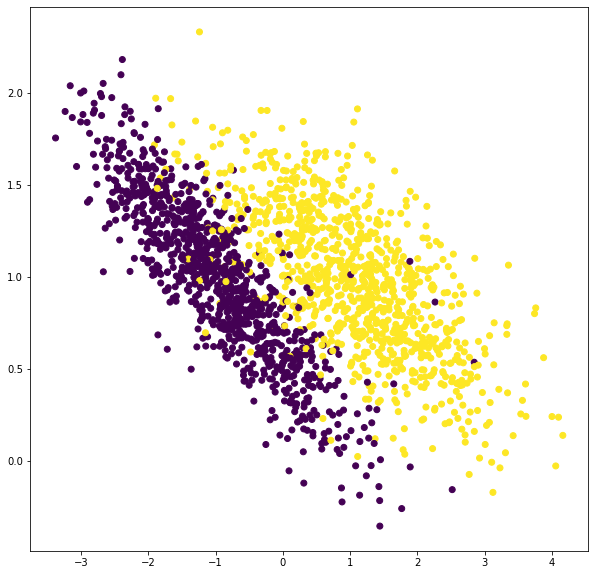

In [297]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

# y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

Czas wykonania wlasna implementacja: 5.32572859999982
Czulosc: 0.9387755102040817
Swoistosc: 0.9166666666666666
Accuracy: 0.9278350515463918
ROC auc: 0.9280851063829787
F1 score: 0.9292929292929293
BA score: 0.9280851063829787


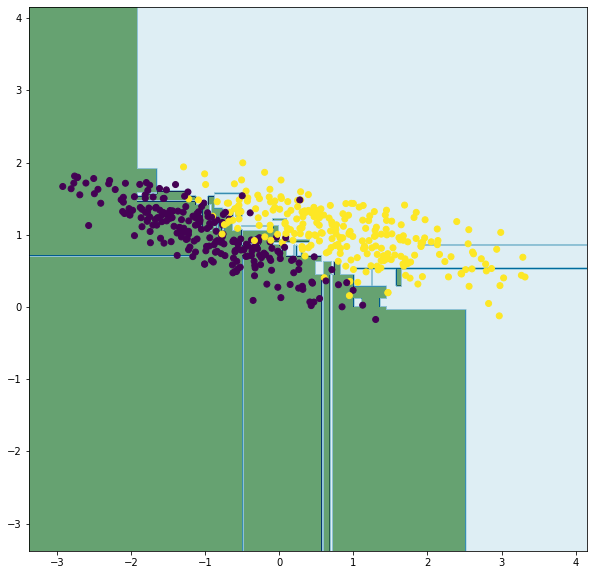

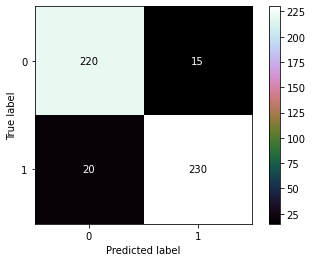

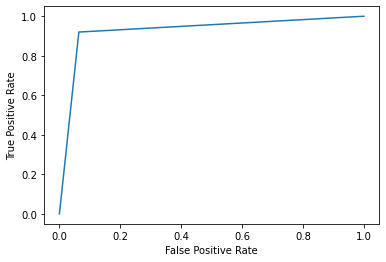

In [298]:
model = MyDecisionTreeClassifier(max_depth=samples, min_samples_split=2)

czasek = time.perf_counter()
for i in range(2):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania wlasna implementacja:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)

Czas wykonania sklearn: 0.007686999999350519
Czulosc: 0.934156378600823
Swoistosc: 0.9049586776859504
Accuracy: 0.9195876288659793
ROC auc: 0.9199574468085105
F1 score: 0.9208924949290062
BA score: 0.9199574468085107


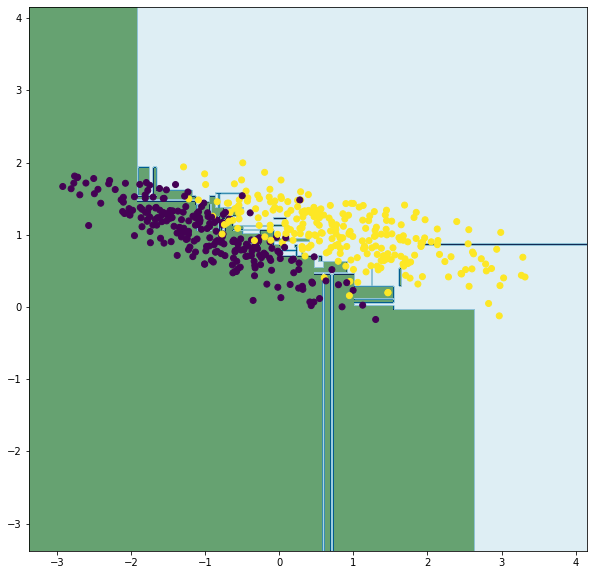

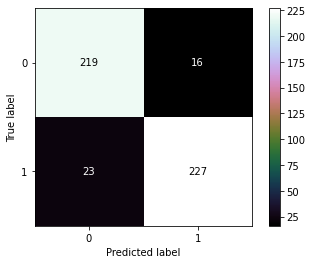

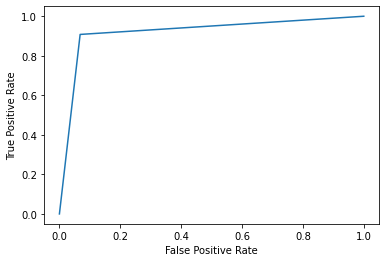

In [299]:
model = DecisionTreeClassifier(max_depth=samples, min_samples_split=2, criterion='entropy')

czasek = time.perf_counter()
for i in range(2):
    tree_function(model, X_train, y_train, X_test, y_test, True)
print('Czas wykonania sklearn:', (time.perf_counter() - czasek))

tree_function(model, X_train, y_train, X_test, y_test)